In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("sales_train.csv")
test  = pd.read_csv("test.csv")

train.columns = train.columns.str.strip()
test.columns  = test.columns.str.strip()

print("train shape:", train.shape)
print("test  shape:", test.shape)

display(train.head())
display(test.head())


train shape: (1482623, 6)
test  shape: (214200, 3)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0.0,59.0,22154.0,999.00,1.0
1,03.01.2013,0.0,25.0,2552.0,899.00,1.0
2,05.01.2013,0.0,25.0,2552.0,899.00,-1.0
3,06.01.2013,0.0,25.0,2554.0,1709.05,1.0
4,15.01.2013,0.0,25.0,2555.0,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [2]:
data_dict = pd.DataFrame({
    "col": train.columns,
    "meaning": [
        "Fecha (día) de la transacción",
        "Índice de mes (0 = primer mes del dataset, 1 = segundo, ...)",
        "ID de tienda/sucursal",
        "ID de producto",
        "Precio observado del producto en esa transacción",
        "Unidades vendidas ese día (puede ser negativa por devoluciones)"
    ]
})
display(data_dict)


,col,meaning
0,date,Fecha (día) de la transacción
1,date_block_num,"Índice de mes (0 = primer mes del dataset, 1 =..."
2,shop_id,ID de tienda/sucursal
3,item_id,ID de producto
4,item_price,Precio observado del producto en esa transacción
5,item_cnt_day,Unidades vendidas ese día (puede ser negativa ...


In [3]:
print(train.info())

nulls = (train.isna().mean().sort_values(ascending=False) * 100).to_frame("% null")
display(nulls)

nulls_test = (test.isna().mean().sort_values(ascending=False) * 100).to_frame("% null")
display(nulls_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482623 entries, 0 to 1482622
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            1482623 non-null  object 
 1   date_block_num  1482622 non-null  float64
 2   shop_id         1482622 non-null  float64
 3   item_id         1482622 non-null  float64
 4   item_price      1482622 non-null  float64
 5   item_cnt_day    1482622 non-null  float64
dtypes: float64(5), object(1)
memory usage: 67.9+ MB
None


,% null
date_block_num,0.000067
shop_id,0.000067
item_price,0.000067
item_id,0.000067
item_cnt_day,0.000067
date,0.000000


,% null
ID,0.0
shop_id,0.0
item_id,0.0


In [4]:
num_cols = ["date_block_num","shop_id","item_id","item_price","item_cnt_day"]
tmp = train[num_cols].apply(pd.to_numeric, errors="coerce")

print("min/max:")
display(pd.DataFrame({"min": tmp.min(), "max": tmp.max(), "n_nan": tmp.isna().sum()}))


min/max:


,min,max,n_nan
date_block_num,0.0,14.0,1
shop_id,0.0,59.0,1
item_id,12.0,22168.0,1
item_price,-1.0,307980.0,1
item_cnt_day,-22.0,288.0,1


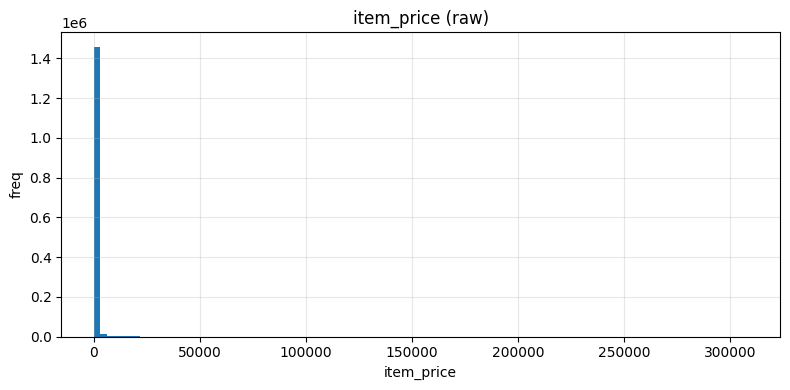

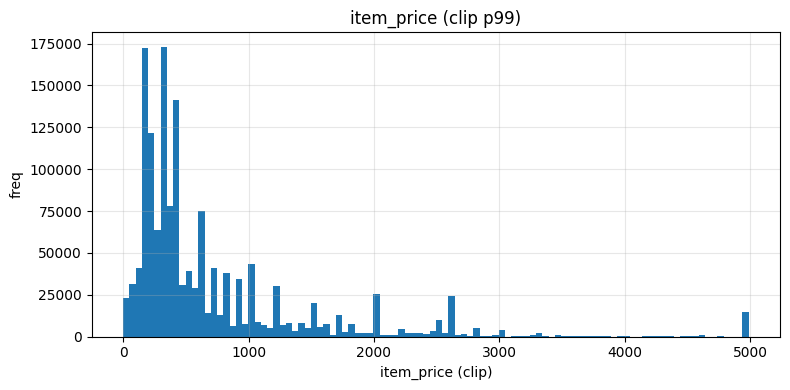

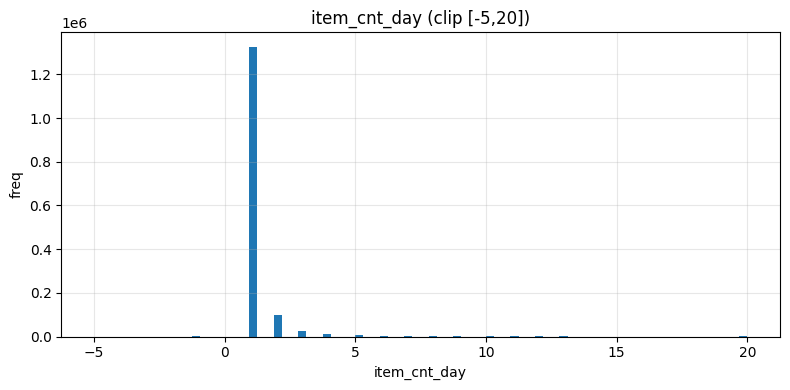

Proporción devoluciones (item_cnt_day < 0): 0.0025245814509699707


In [5]:
tmp = train.copy()
tmp["item_price"] = pd.to_numeric(tmp["item_price"], errors="coerce")
tmp["item_cnt_day"] = pd.to_numeric(tmp["item_cnt_day"], errors="coerce")

p = tmp["item_price"].dropna()

plt.figure(figsize=(8,4))
plt.hist(p, bins=100)
plt.title("item_price (raw)")
plt.xlabel("item_price")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(p.clip(upper=p.quantile(0.99)), bins=100)
plt.title("item_price (clip p99)")
plt.xlabel("item_price (clip)")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

c = tmp["item_cnt_day"].dropna()

plt.figure(figsize=(8,4))
plt.hist(c.clip(-5, 20), bins=80)
plt.title("item_cnt_day (clip [-5,20])")
plt.xlabel("item_cnt_day")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Proporción devoluciones (item_cnt_day < 0):", (c < 0).mean())


date range: 2013-01-01 00:00:00 -> 2014-03-31 00:00:00
date_block_num range: 0.0 -> 14.0
n meses distintos: 15


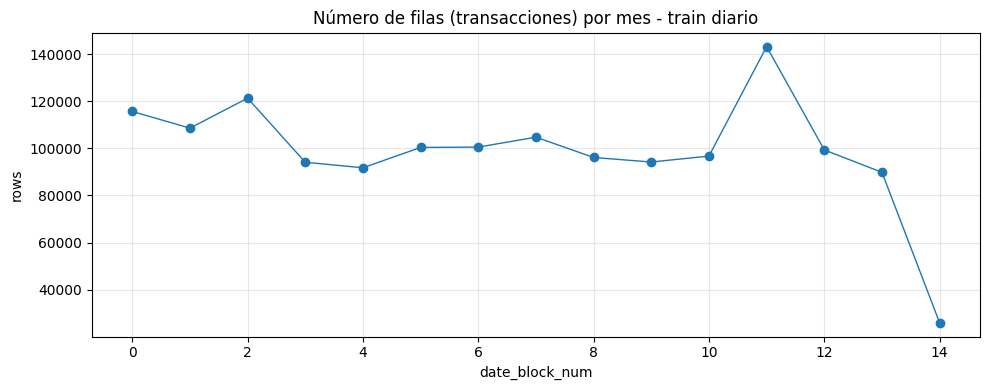

In [6]:
tmp = train.copy()
tmp["date"] = pd.to_datetime(tmp["date"], format="%d.%m.%Y", errors="coerce")

print("date range:", tmp["date"].min(), "->", tmp["date"].max())
print("date_block_num range:", tmp["date_block_num"].min(), "->", tmp["date_block_num"].max())
print("n meses distintos:", tmp["date_block_num"].nunique())

m_rows = tmp.groupby("date_block_num").size()

plt.figure(figsize=(10,4))
plt.plot(m_rows.index, m_rows.values, marker="o", linewidth=1)
plt.title("Número de filas (transacciones) por mes - train diario")
plt.xlabel("date_block_num")
plt.ylabel("rows")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
tmp = train.copy()
tmp["item_cnt_day"] = pd.to_numeric(tmp["item_cnt_day"], errors="coerce").fillna(0)
tmp["item_price"]   = pd.to_numeric(tmp["item_price"], errors="coerce")

monthly = (
    tmp.groupby(["date_block_num","shop_id","item_id"], as_index=False)
       .agg(item_cnt_month=("item_cnt_day","sum"),
            price_mean=("item_price","mean"))
)

monthly["item_cnt_month_clip"] = monthly["item_cnt_month"].clip(0, 20)

print("monthly shape:", monthly.shape)
display(monthly.head())


monthly shape: (802767, 6)


,date_block_num,shop_id,item_id,item_cnt_month,price_mean,item_cnt_month_clip
0,0.0,0.0,32.0,6.0,221.0,6.0
1,0.0,0.0,33.0,3.0,347.0,3.0
2,0.0,0.0,35.0,1.0,247.0,1.0
3,0.0,0.0,43.0,1.0,221.0,1.0
4,0.0,0.0,51.0,2.0,128.5,2.0


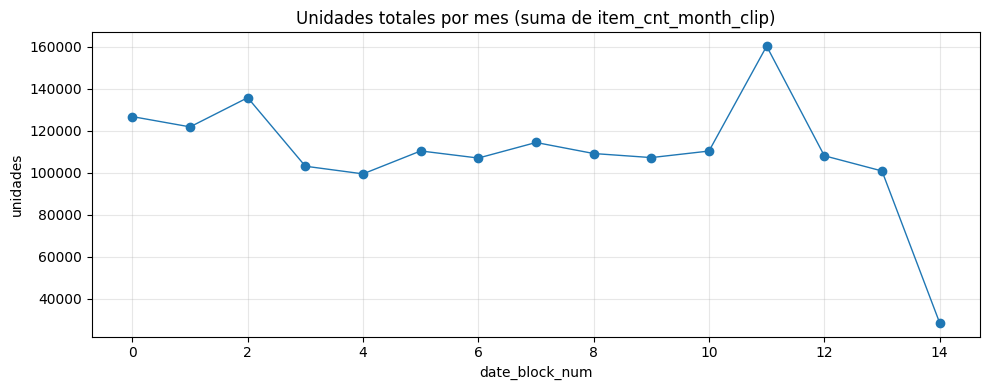

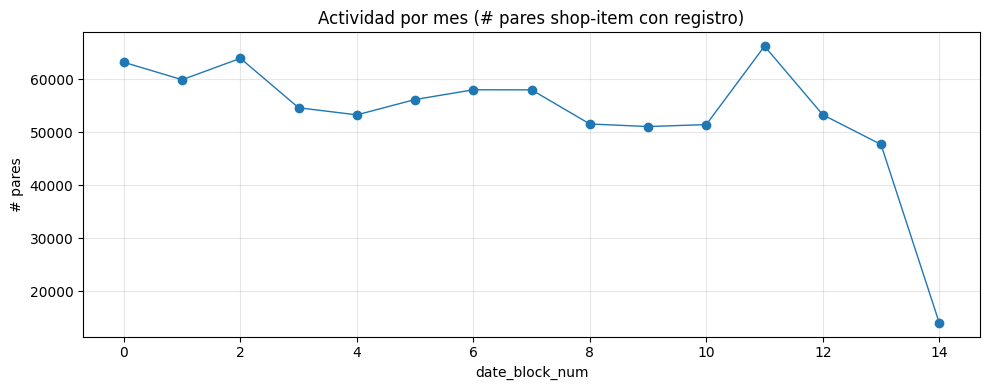

In [8]:
m_units = monthly.groupby("date_block_num")["item_cnt_month_clip"].sum()
m_pairs = monthly.groupby("date_block_num").size()

plt.figure(figsize=(10,4))
plt.plot(m_units.index, m_units.values, marker="o", linewidth=1)
plt.title("Unidades totales por mes (suma de item_cnt_month_clip)")
plt.xlabel("date_block_num")
plt.ylabel("unidades")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(m_pairs.index, m_pairs.values, marker="o", linewidth=1)
plt.title("Actividad por mes (# pares shop-item con registro)")
plt.xlabel("date_block_num")
plt.ylabel("# pares")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


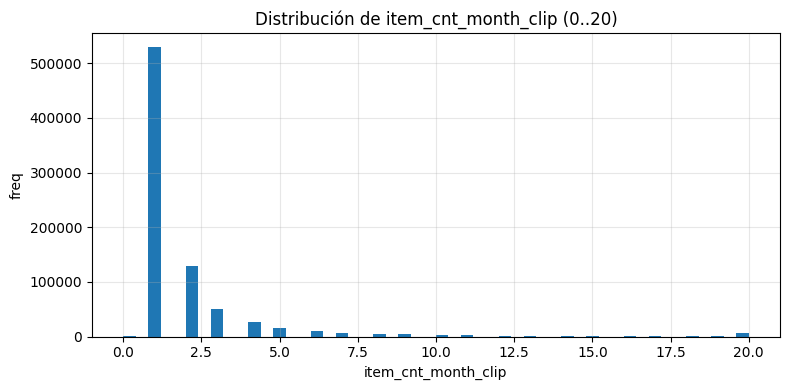

Proporción de ceros (en monthly observado): 0.0021812057545962903
Pares únicos (shop,item) observados en train: 279259
Pares únicos en test: 214200


In [9]:
y = monthly["item_cnt_month_clip"]
plt.figure(figsize=(8,4))
plt.hist(y, bins=50)
plt.title("Distribución de item_cnt_month_clip (0..20)")
plt.xlabel("item_cnt_month_clip")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Proporción de ceros (en monthly observado):", (y == 0).mean())

n_pairs_total = monthly[["shop_id","item_id"]].drop_duplicates().shape[0]
print("Pares únicos (shop,item) observados en train:", n_pairs_total)
print("Pares únicos en test:", test[["shop_id","item_id"]].drop_duplicates().shape[0])


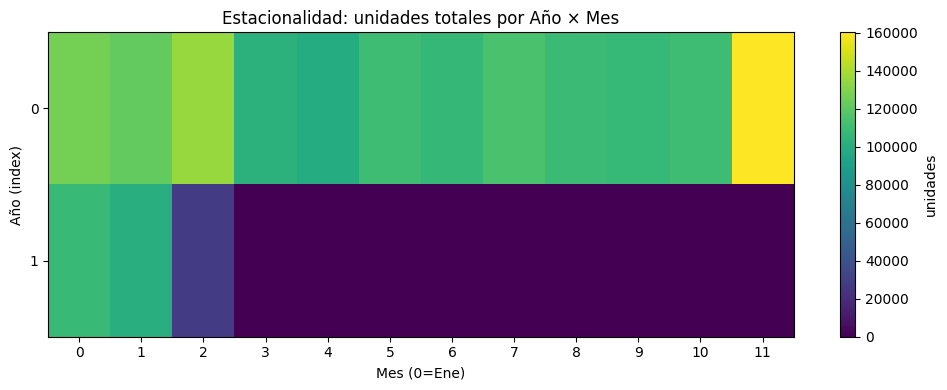

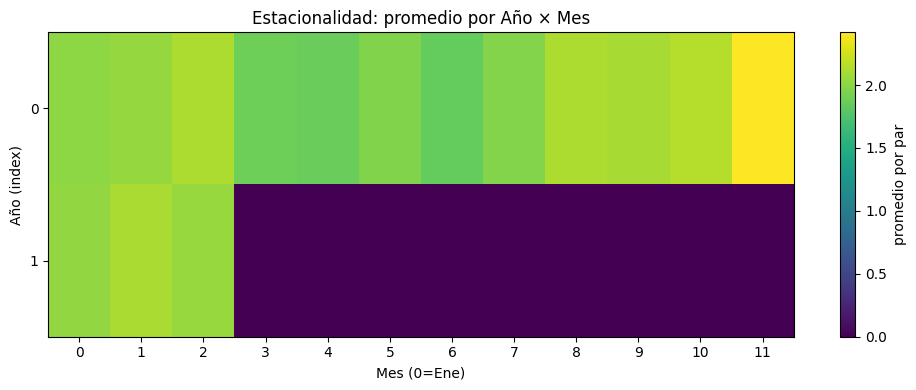

In [10]:
monthly["month"] = (monthly["date_block_num"] % 12).astype(int)
monthly["year"]  = (monthly["date_block_num"] // 12).astype(int)

season = monthly.groupby(["year","month"])["item_cnt_month_clip"].sum().unstack("month").fillna(0)

plt.figure(figsize=(10,4))
plt.imshow(season.values, aspect="auto")
plt.title("Estacionalidad: unidades totales por Año × Mes")
plt.xlabel("Mes (0=Ene)")
plt.ylabel("Año (index)")
plt.xticks(range(12), range(12))
plt.yticks(range(len(season.index)), season.index)
plt.colorbar(label="unidades")
plt.tight_layout()
plt.show()

season_mean = monthly.groupby(["year","month"])["item_cnt_month_clip"].mean().unstack("month").fillna(0)

plt.figure(figsize=(10,4))
plt.imshow(season_mean.values, aspect="auto")
plt.title("Estacionalidad: promedio por Año × Mes")
plt.xlabel("Mes (0=Ene)")
plt.ylabel("Año (index)")
plt.xticks(range(12), range(12))
plt.yticks(range(len(season_mean.index)), season_mean.index)
plt.colorbar(label="promedio por par")
plt.tight_layout()
plt.show()


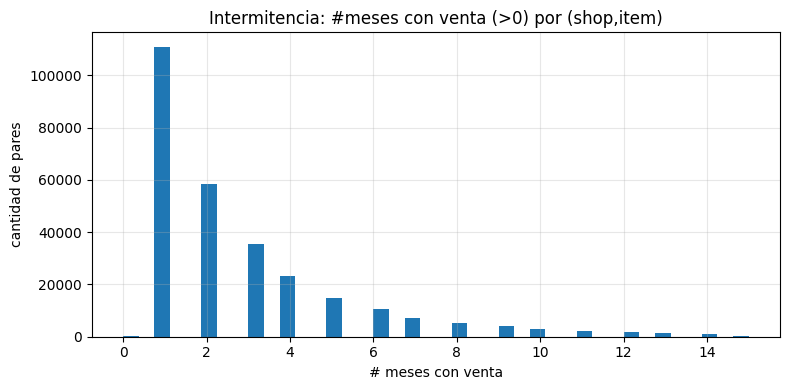

Percentiles #meses con venta: {0.5: 2.0, 0.75: 4.0, 0.9: 6.0, 0.95: 8.0, 0.99: 12.0}


In [11]:
m2 = monthly.copy()
m2["sold"] = (m2["item_cnt_month_clip"] > 0).astype(int)
months_sold = (m2.groupby(["shop_id","item_id"])["sold"].sum())

plt.figure(figsize=(8,4))
plt.hist(months_sold, bins=40)
plt.title("Intermitencia: #meses con venta (>0) por (shop,item)")
plt.xlabel("# meses con venta")
plt.ylabel("cantidad de pares")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Percentiles #meses con venta:", months_sold.quantile([0.5,0.75,0.9,0.95,0.99]).to_dict())


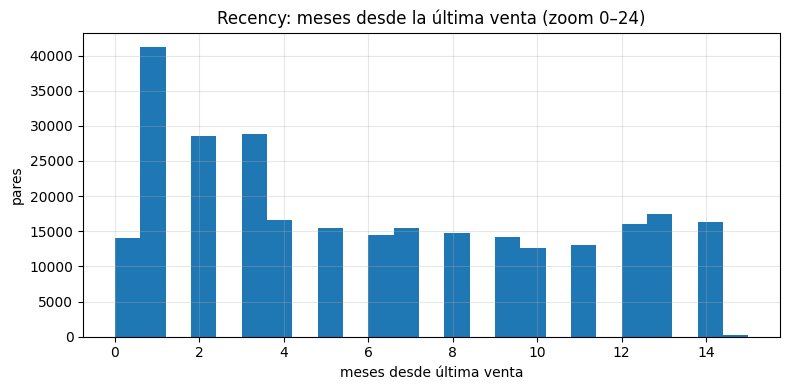

In [12]:
max_m = int(monthly["date_block_num"].max())
last_sale = (monthly.loc[monthly["item_cnt_month_clip"] > 0]
                  .groupby(["shop_id","item_id"])["date_block_num"].max())

recency = (max_m - last_sale).reindex(
    monthly[["shop_id","item_id"]].drop_duplicates().set_index(["shop_id","item_id"]).index
)
recency = recency.fillna(max_m + 1)

plt.figure(figsize=(8,4))
plt.hist(recency.clip(0, 24), bins=25)
plt.title("Recency: meses desde la última venta (zoom 0–24)")
plt.xlabel("meses desde última venta")
plt.ylabel("pares")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


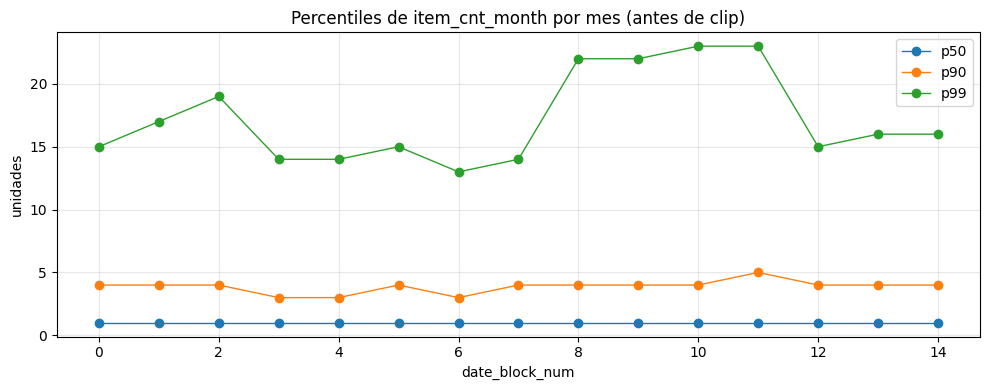

In [13]:
q = (monthly.groupby("date_block_num")["item_cnt_month"]
            .quantile([0.5, 0.9, 0.99])
            .unstack())

plt.figure(figsize=(10,4))
plt.plot(q.index, q[0.5], marker="o", linewidth=1, label="p50")
plt.plot(q.index, q[0.9], marker="o", linewidth=1, label="p90")
plt.plot(q.index, q[0.99], marker="o", linewidth=1, label="p99")
plt.title("Percentiles de item_cnt_month por mes (antes de clip)")
plt.xlabel("date_block_num")
plt.ylabel("unidades")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


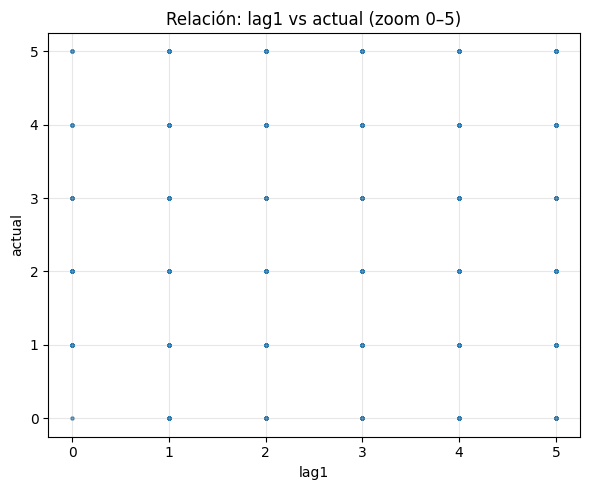

In [14]:
m3 = monthly.sort_values(["shop_id","item_id","date_block_num"]).copy()
m3["lag1"] = m3.groupby(["shop_id","item_id"])["item_cnt_month_clip"].shift(1)
tmp = m3.dropna(subset=["lag1"])

plt.figure(figsize=(6,5))
plt.scatter(tmp["lag1"].clip(0,5), tmp["item_cnt_month_clip"].clip(0,5), s=4, alpha=0.15)
plt.title("Relación: lag1 vs actual (zoom 0–5)")
plt.xlabel("lag1")
plt.ylabel("actual")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
